In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [3]:
NOISE_DIM = 128 # 64 in Gitlab
TESTING= False
BATCH_SIZE = 64
SAMPLE_SIZE= 50000
BINS = 25
filenames = {
    "herwig": "../GAN-data/events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "../GAN-data/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "../GAN-data/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]

train_features = ["ptj1", "etaj1", "mj1", "ptj2", "etaj2", "phij2", "mj2", "tau21j1", "tau21j2"]
condition_features = ["mjj"]

features = train_features + condition_features
GEN_DIM = NOISE_DIM + len(condition_features)
DISC_DIM = len(features)

In [4]:
def cut_data(uncut_data, pTmin = 1200, etamax = 2.5):
    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
    return uncut_data[((uncut_data[:,0] > pTmin) & (np.abs(uncut_data[:,1]) < etamax)) | ((uncut_data[:,3] > pTmin) & (np.abs(uncut_data[:,4]) < etamax))]

np_bg_SB = np.load('./data/processed/np_bg_SB_2.npy')
np_bg_SR = np.load('./data/processed/np_bg_SR_2.npy')
np_sig_SR = np.load('./data/processed/np_sig_SR_2.npy')

np_sig_SR_labeled = np.copy(np_sig_SR)
np_bg_SR_labeled = np.copy(np_bg_SR)
#add sb label
np_sig_SR_labeled = np.append(np_sig_SR_labeled,np.ones([len(np_sig_SR),1]),1)
np_bg_SR_labeled = np.append(np_bg_SR_labeled,np.zeros([len(np_bg_SR),1]),1)

np_combined_SR = np.concatenate((np_bg_SR, np_sig_SR), axis = 0)
np_combined_SR_labeled = np.concatenate((np_sig_SR_labeled,np_bg_SR_labeled),axis=0)

gc.collect()

9

In [5]:
def generate_gan(generator, realdata):


    labels = sample_fake(refdata = realdata, size = SAMPLE_SIZE) # Sample mjj from the existing distribution of mjj for comparison
    labels_scaled = scaler_mjj.transform(labels.reshape(-1,1))
    
    fakedata_uncut_unscaled = generator(tf.concat([tf.random.uniform((SAMPLE_SIZE, NOISE_DIM)), labels_scaled], 1), training=False)
    fakedata_uncut = np.concatenate((scaler.inverse_transform(fakedata_uncut_unscaled), labels.reshape(-1,1)), axis = 1)
   

    # At least one jet has pT > 1200 and |eta| < 2.5
    fakedata = cut_data(fakedata_uncut)

    # mjj = sqrt(Ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    fakedata_mjj = mjj(fakedata)

    return fakedata
def mjj(output):
    pt1 = output[:,0]
    eta1 = output[:,1]
    m1 = output[:,2]
    pt2 = output[:,3]
    eta2 = output[:,4]
    phi2 = output[:,5]
    m2 = output[:,6]
    ejj = np.sqrt((pt1 * np.cosh(eta1))**2 + m1**2) + np.sqrt((pt2 * np.cosh(eta2))**2 + m2**2)
    pxjj = pt1 + pt2 * np.cos(phi2)
    pyjj = pt2 * np.sin(phi2)
    pzjj = pt1 * np.sinh(eta1) + pt2 * np.sinh(eta2)
    return np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
def sample_fake(refdata = np_combined_SR, size = BATCH_SIZE):
    rand_idx = np.random.choice(refdata.shape[0], size = size)
    return refdata[rand_idx, -1].reshape((-1,1))
def sample_data(refdata = np_combined_SR_labeled,size= 10000):
    rand_idx = np.random.choice(refdata.shape[0], size)
    return refdata[rand_idx, :]


In [6]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      
]
def classifier_model():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(64,input_dim = 4,activation ='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[METRICS])
    return model

def learningCurveLoss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()
    #plt.savefig("Learning_Curve")
def plot_roc_curve(y_test, y_test_score):

    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    auc_value = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()


In [7]:
np_bg_SB_trimmed = np.delete(np_bg_SB, [i for i in range(np_bg_SB.shape[0] % (BATCH_SIZE * 4))], axis = 0)

# Normalize inputs between -1 and 1, mjj between 0 and 1
scaler = MinMaxScaler((-1,1)).fit(np_bg_SB_trimmed[:,:-1])
scaler_mjj = MinMaxScaler((0,1)).fit(np_bg_SB_trimmed[:,-1].reshape(-1,1))
np_bg_SB_scaled = np.concatenate((scaler.transform(np_bg_SB_trimmed[:,:-1]), scaler_mjj.transform(np_bg_SB_trimmed[:,-1].reshape(-1,1))), axis = 1)

In [8]:
gen_model = tf.keras.models.load_model('./Results/epoch1000-generator.h5')

In [9]:
train_bg,test_bg,train_sb,test_sb =train_test_split(np_bg_SR_labeled[:,0:10],np_bg_SR_labeled[:,-1], test_size = 0.5, random_state=42)
sb = train_sb.reshape(len(train_sb),1)
training_dataset =  np.concatenate((train_bg,sb),axis=1)
test_dataset = np.concatenate((test_bg,sb),axis=1)


In [10]:
print(train_bg.shape)
print(train_sb.shape)
print(test_bg.shape)
print(test_sb.shape)

(121338, 10)
(121338,)
(121338, 10)
(121338,)


In [11]:
testing_sample = np.concatenate((np_sig_SR_labeled,test_dataset),axis=0)

In [12]:
sb_ratio = np.logspace(-3,-0.205,6)
mixedSRsample = []
generated_data = []

In [13]:
sampled_signal = np.random.choice(np_sig_SR_labeled.shape[0], (int)(sb_ratio[5] * training_dataset.shape[0]))
combined = np.concatenate((np_sig_SR_labeled[sampled_signal,:],training_dataset), axis =0)

In [15]:
sb_ratio = np.logspace(-3,-0.205,5)
#sb_ratio = np.linspace(0,0.62,10)
mixedsb = []
generated_data = []
test_data = []
for i in sb_ratio:
    sampled_signal = np.random.choice(np_sig_SR_labeled.shape[0], (int)(i * training_dataset.shape[0]))
    combined = np.concatenate((np_sig_SR_labeled[sampled_signal,:],training_dataset), axis =0)
    gen = generate_gan(gen_model,combined[:,0:10])
    gen2 = generate_gan(gen_model,combined[:,0:10])
    gen_data = np.concatenate((gen,gen2),axis=0)
    generated_data_labeled  = np.copy(gen_data)
    generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1)
    mixedsb.append(sample_data(combined,100000))
    generated_data.append(generated_data_labeled)
    test_data.append(sample_data(testing_sample,100000))
    

In [16]:
gen_data_df = pd.DataFrame(generated_data[0], columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sb'])

In [17]:
gen_data_df

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sb
0,1791.820131,-0.813664,131.139113,1775.982553,-0.696783,3.112136,365.135190,0.575299,0.365421,3458.918213,0.0
1,1294.594193,-1.294885,239.368582,780.168350,0.994845,3.736121,190.902767,0.301583,0.503116,3641.683594,0.0
2,1536.494378,-0.666997,289.563905,1401.128847,0.628420,2.941548,720.990691,0.849731,0.364243,3593.330322,0.0
3,1263.772346,-0.822351,324.560031,980.016455,1.165107,3.275835,271.560185,0.354469,0.516781,3463.776855,0.0
4,1301.192193,-0.286662,204.042814,1279.784783,-1.855172,3.207636,299.649656,0.671097,0.300150,3370.902832,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,1419.740558,0.011402,489.462208,1409.063755,1.393021,3.145011,211.321501,0.629387,0.527988,3472.135742,0.0
99996,1956.181122,-0.877719,153.086026,1641.175362,-0.355862,3.327273,159.663929,0.614305,0.417282,3588.239502,0.0
99997,1477.572530,0.373652,116.800234,1276.220913,-1.007233,3.169739,300.171710,0.861720,0.745371,3351.192383,0.0
99998,1472.948548,-0.980025,562.861320,1165.864539,0.696812,3.274006,121.171925,0.102565,0.461296,3529.704834,0.0


In [20]:
for i in range(len(generated_data)):
    unique, counts = np.unique(generated_data[i][:,-1], return_counts=True)
    print(dict(zip(unique, counts)))

{0.0: 100000}
{0.0: 100000}
{0.0: 100000}
{0.0: 100000}
{0.0: 100000}


In [21]:
mixedsb_df = pd.DataFrame(mixedsb[0], columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sb'])

In [22]:
mixedsb_df

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sb
0,1267.020630,-0.010235,659.312988,1218.073242,1.546834,3.168326,134.449997,0.513791,0.552259,3487.051514,0.0
1,1686.311646,0.133335,510.855011,1489.014404,-0.704626,3.178216,174.311005,0.105699,0.765256,3537.022461,0.0
2,1441.320190,0.885924,448.165009,1279.833862,-0.561815,2.986546,371.608002,0.286383,0.335408,3549.600342,0.0
3,1335.151123,0.199335,67.093597,1083.000610,-1.564072,2.933065,124.042999,0.686199,0.727930,3398.099609,0.0
4,1873.412720,-0.270098,105.387001,1584.817139,-0.224228,3.305163,291.834991,0.507046,0.769515,3465.509521,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,1859.343262,0.131407,185.393997,1489.940063,-0.281404,3.018929,371.178009,0.137047,0.367211,3447.341553,0.0
99996,1700.963501,-0.742790,78.665298,1590.598145,-0.686662,3.293440,416.375000,0.279720,0.629058,3338.195068,0.0
99997,1379.032593,1.018103,56.526299,1302.863647,-0.485001,3.220242,222.005005,0.747339,0.585485,3490.888428,0.0
99998,1732.231812,0.130711,1117.640015,1423.270142,-0.024353,3.031418,176.518005,0.486963,0.669206,3485.336182,0.0


In [24]:
for i in range(len(mixedsb)):
    unique, counts = np.unique(mixedsb[i][:,-1], return_counts=True)
    print(dict(zip(unique, counts)))

{0.0: 99904, 1.0: 96}
{0.0: 99519, 1.0: 481}
{0.0: 97532, 1.0: 2468}
{0.0: 88788, 1.0: 11212}
{0.0: 61604, 1.0: 38396}


In [35]:
mixedsb[0][:,-1].shape

(100000,)

In [36]:
dataset = []
for i in range(len(mixedsb)):
    classifier_real = mixedsb[i][:,[2,6,7,8]]
    classifier_fake = generated_data[i][:,[2,6,7,8]]
    sblabel_real = mixedsb[i][:,-1]
    sblabel_fake = generated_data[i][:,-1]
    sblabel_real = sblabel_real.reshape(len(sblabel_real),1)
    sblabel_fake = sblabel_fake.reshape(len(sblabel_fake),1)
    rf_label_real = np.ones([len(classifier_real),1])
    rf_label_fake = np.zeros([len(classifier_fake),1])
    classifier_real = np.concatenate((classifier_real,sblabel_real),axis=1)
    classifier_fake = np.concatenate((classifier_fake,sblabel_fake),axis=1)
    classifier_real = np.concatenate((classifier_real,rf_label_real),axis=1)
    classifier_fake = np.concatenate((classifier_fake,rf_label_fake),axis=1)
    print(classifier_real.shape)
    data = np.concatenate((classifier_real,classifier_fake),axis=0)
    dataset.append(data)

(100000, 6)
(100000, 6)
(100000, 6)
(100000, 6)
(100000, 6)


In [29]:
rf_label_real.shape

(100000, 1)

In [37]:
class_real_df = pd.DataFrame(dataset[0], columns = ['m1','m2','tau21j1','tau21j2','sb','rf'])

In [38]:
class_real_df

,m1,m2,tau21j1,tau21j2,sb,rf
0,659.312988,134.449997,0.513791,0.552259,0.0,1.0
1,510.855011,174.311005,0.105699,0.765256,0.0,1.0
2,448.165009,371.608002,0.286383,0.335408,0.0,1.0
3,67.093597,124.042999,0.686199,0.727930,0.0,1.0
4,105.387001,291.834991,0.507046,0.769515,0.0,1.0
...,...,...,...,...,...,...
199995,489.462208,211.321501,0.629387,0.527988,0.0,0.0
199996,153.086026,159.663929,0.614305,0.417282,0.0,0.0
199997,116.800234,300.171710,0.861720,0.745371,0.0,0.0
199998,562.861320,121.171925,0.102565,0.461296,0.0,0.0


Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 58us/sample - loss: 0.7442 - tp: 46520.0000 - fp: 42583.0000 - tn: 37410.0000 - fn: 33487.0000 - accuracy: 0.5246 - precision: 0.5221 - recall: 0.5814 - auc: 0.5301 - val_loss: 0.6898 - val_tp: 17433.0000 - val_fp: 16381.0000 - val_tn: 3626.0000 - val_fn: 2560.0000 - val_accuracy: 0.5265 - val_precision: 0.5156 - val_recall: 0.8720 - val_auc: 0.5651
Epoch 2/10
160000/160000 [==============================] - 8s 47us/sample - loss: 0.6889 - tp: 53281.0000 - fp: 47618.0000 - tn: 32375.0000 - fn: 26726.0000 - accuracy: 0.5354 - precision: 0.5281 - recall: 0.6660 - auc: 0.5537 - val_loss: 0.6880 - val_tp: 15841.0000 - val_fp: 14500.0000 - val_tn: 5507.0000 - val_fn: 4152.0000 - val_accuracy: 0.5337 - val_precision: 0.5221 - val_recall: 0.7923 - val_auc: 0.5657
Epoch 3/10
160000/160000 [==============================] - 8s 47us/sample - loss: 0.6885 - tp: 54217.0000 - fp: 48213.

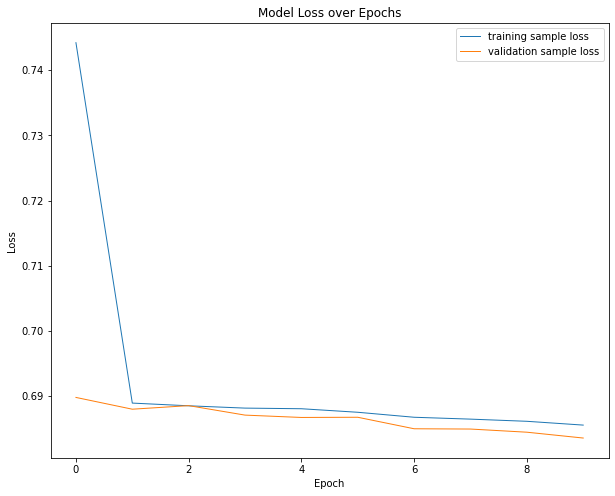

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 57us/sample - loss: 0.7304 - tp: 46273.0000 - fp: 42789.0000 - tn: 37204.0000 - fn: 33734.0000 - accuracy: 0.5217 - precision: 0.5196 - recall: 0.5784 - auc: 0.5260 - val_loss: 0.6892 - val_tp: 16051.0000 - val_fp: 14762.0000 - val_tn: 5245.0000 - val_fn: 3942.0000 - val_accuracy: 0.5324 - val_precision: 0.5209 - val_recall: 0.8028 - val_auc: 0.5608
Epoch 2/10
160000/160000 [==============================] - 8s 48us/sample - loss: 0.6895 - tp: 52961.0000 - fp: 47451.0000 - tn: 32542.0000 - fn: 27046.0000 - accuracy: 0.5344 - precision: 0.5274 - recall: 0.6620 - auc: 0.5497 - val_loss: 0.6912 - val_tp: 17705.0000 - val_fp: 16813.0000 - val_tn: 3194.0000 - val_fn: 2288.0000 - val_accuracy: 0.5225 - val_precision: 0.5129 - val_recall: 0.8856 - val_auc: 0.5555
Epoch 3/10
160000/160000 [==============================] - 8s 48us/sample - loss: 0.6887 - tp: 53366.0000 - fp: 47584.

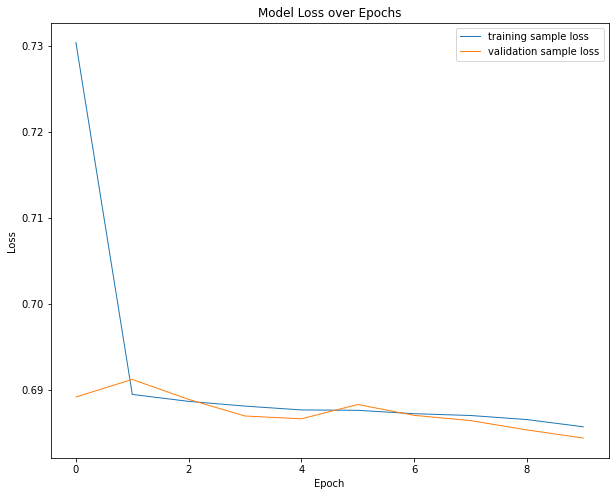

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 57us/sample - loss: 0.7829 - tp: 45624.0000 - fp: 42671.0000 - tn: 37322.0000 - fn: 34383.0000 - accuracy: 0.5184 - precision: 0.5167 - recall: 0.5703 - auc: 0.5231 - val_loss: 0.6890 - val_tp: 15027.0000 - val_fp: 13764.0000 - val_tn: 6243.0000 - val_fn: 4966.0000 - val_accuracy: 0.5318 - val_precision: 0.5219 - val_recall: 0.7516 - val_auc: 0.5569
Epoch 2/10
160000/160000 [==============================] - 8s 48us/sample - loss: 0.6901 - tp: 51664.0000 - fp: 46733.0000 - tn: 33260.0000 - fn: 28343.0000 - accuracy: 0.5308 - precision: 0.5251 - recall: 0.6457 - auc: 0.5456 - val_loss: 0.6878 - val_tp: 11824.0000 - val_fp: 10351.0000 - val_tn: 9656.0000 - val_fn: 8169.0000 - val_accuracy: 0.5370 - val_precision: 0.5332 - val_recall: 0.5914 - val_auc: 0.5558
Epoch 3/10
160000/160000 [==============================] - 8s 48us/sample - loss: 0.6893 - tp: 52130.0000 - fp: 46948.

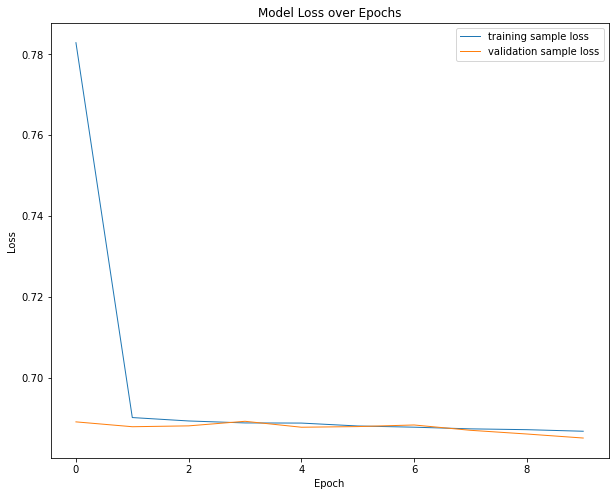

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 59us/sample - loss: 0.8004 - tp: 42148.0000 - fp: 39133.0000 - tn: 40860.0000 - fn: 37859.0000 - accuracy: 0.5188 - precision: 0.5185 - recall: 0.5268 - auc: 0.5234 - val_loss: 0.6888 - val_tp: 9050.0000 - val_fp: 7631.0000 - val_tn: 12376.0000 - val_fn: 10943.0000 - val_accuracy: 0.5357 - val_precision: 0.5425 - val_recall: 0.4527 - val_auc: 0.5495
Epoch 2/10
160000/160000 [==============================] - 8s 48us/sample - loss: 0.6900 - tp: 46220.0000 - fp: 41336.0000 - tn: 38657.0000 - fn: 33787.0000 - accuracy: 0.5305 - precision: 0.5279 - recall: 0.5777 - auc: 0.5467 - val_loss: 0.6882 - val_tp: 14959.0000 - val_fp: 13554.0000 - val_tn: 6453.0000 - val_fn: 5034.0000 - val_accuracy: 0.5353 - val_precision: 0.5246 - val_recall: 0.7482 - val_auc: 0.5575
Epoch 3/10
160000/160000 [==============================] - 8s 48us/sample - loss: 0.6879 - tp: 48095.0000 - fp: 42243.

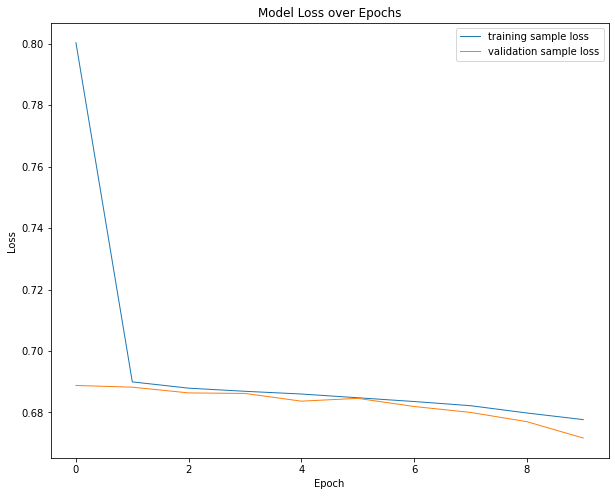

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 57us/sample - loss: 0.7358 - tp: 26585.0000 - fp: 19103.0000 - tn: 60890.0000 - fn: 53422.0000 - accuracy: 0.5467 - precision: 0.5819 - recall: 0.3323 - auc: 0.5540 - val_loss: 0.6769 - val_tp: 4919.0000 - val_fp: 2283.0000 - val_tn: 17724.0000 - val_fn: 15074.0000 - val_accuracy: 0.5661 - val_precision: 0.6830 - val_recall: 0.2460 - val_auc: 0.5723
Epoch 2/10
160000/160000 [==============================] - 8s 47us/sample - loss: 0.6738 - tp: 29322.0000 - fp: 18841.0000 - tn: 61152.0000 - fn: 50685.0000 - accuracy: 0.5655 - precision: 0.6088 - recall: 0.3665 - auc: 0.5967 - val_loss: 0.6618 - val_tp: 11092.0000 - val_fp: 7491.0000 - val_tn: 12516.0000 - val_fn: 8901.0000 - val_accuracy: 0.5902 - val_precision: 0.5969 - val_recall: 0.5548 - val_auc: 0.6254
Epoch 3/10
160000/160000 [==============================] - 8s 47us/sample - loss: 0.6666 - tp: 43198.0000 - fp: 29923.

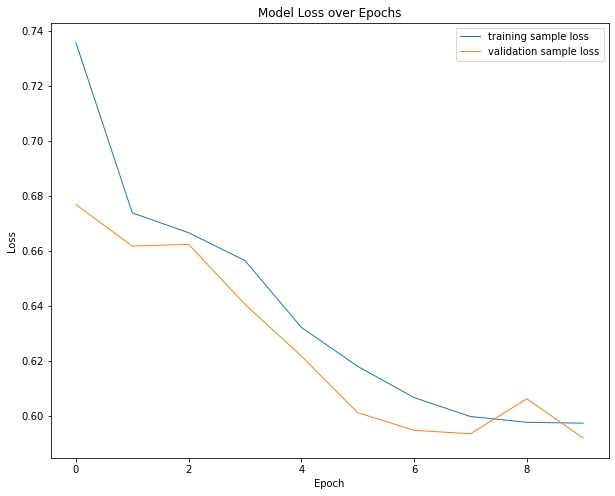

In [40]:
ypred4c = []
fp_4c, tp_4c,th_4c= [],[],[]
auc_list_4c = []
for i in range(len(mixedsb)): 
    x_train,x_val,y_train,y_val = train_test_split(dataset[i][:,0:4],dataset[i][:,-1], test_size = 0.2, random_state=42)
    x_test,sby_test = test_data[i][:,0:4],test_data[i][:,-1]
    classifier = classifier_model()
    history = classifier.fit(x_train, y_train, epochs=10, batch_size=64,validation_data=(x_val,y_val))
    learningCurveLoss(history)
    y_pred = classifier.predict(x_test)
    ypred4c.append(y_pred)
    fpr, tpr, thresholds = roc_curve(sby_test, y_pred)
    auc_value = auc(fpr,tpr)
    auc_list_4c.append(auc_value)
    fp_4c.append(fpr)
    tp_4c.append(tpr)
    th_4c.append(thresholds)  

In [47]:
eff_ratio = []
for i in range(len(tp_4c)):
    tp_4c[i] = tp_4c[i] + 0.0000001
    fp_4c[i] = fp_4c[i] + 0.0000001
    eff_ratio.append(max(tp_c[i]/np.sqrt(fp_c[i])))# * (sb_ratio[i] * np_bg_SR.shape[0])/(np.sqrt(np_bg_SR.shape[0])))
    

NameError: name 'tp_c' is not defined